In [1]:
#import sympy as sym
import numpy as np
import sys

import pandas as pd
import matplotlib.pyplot as plt
#import datetime as dt
import numpy as np
#import seaborn as sns
import scipy.interpolate
from scipy.ndimage import gaussian_filter1d


In [4]:
USE_SOFTMAX = False

def softmax(X):
  if USE_SOFTMAX:
    vmax = np.max(X) # prevent overflow..
    exs = np.exp(X - vmax)
    return exs / np.sum(exs)
  else:
    return X

def relu(x):
  return np.maximum(0, x)

def drelu(X):
  return np.greater(X, 0).astype(int)

def logNorm(X, scale, sigma, mu):
  return scale * (np.exp(-(np.log(X) - mu)**2 / (2 * sigma**2)) / (X * sigma * np.sqrt(2 * np.pi)))

def dlogN_scale( X, scale, sigma, mu):
  return np.sqrt(2)*np.exp(-(mu - np.log(X))**2/(2*sigma**2))/(2*np.sqrt(np.pi)*sigma*X)

def dlogN_sigma( X, scale, sigma, mu):
  return np.sqrt(2)*scale*(-sigma**2 + (mu - np.log(X))**2)*np.exp(-(mu - np.log(X))**2/(2*sigma**2))/(2*np.sqrt(np.pi)*sigma**4*X)

def dlogN_mu( X, scale, sigma, mu):
  return -np.sqrt(2)*scale*(mu - np.log(X))*np.exp(-(mu - np.log(X))**2/(2*sigma**2))/(2*np.sqrt(np.pi)*sigma**3*X)

def dlogN_X( X, scale, sigma, mu):
  return np.sqrt(2)*scale*(mu - sigma**2 - np.log(X))*np.exp(-(mu - np.log(X))**2/(2*sigma**2))/(2*np.sqrt(np.pi)*sigma**3*X**2)

class GradDescentAlg:
  def __init__(self, scale, bias, mu, sigmaInc):
    self.scale = np.log(scale) if USE_SOFTMAX else scale
    self.bias = bias
    self.mu = np.float64(mu)
    self.sigmaInc = sigmaInc
    self.total = len(self.bias)

  # derivative of softmax function: dsoftmax(scale[i])/dscale[j]
  def dscale_i(self, i, j):
    if USE_SOFTMAX:
      vmax = np.max(self.scale)
      ss = np.exp(self.scale - vmax)
      S = sum(ss)
      d = ss[i] / S
      if i == j:
        return d*(1 - d)
      else: # not equal
        return d *(ss[j] / S)
    else:
      return 1 if i == j else 0

  # dsigma[i]/digmainc[j]
  def dsigmaInc_i(self, i, j):
    return 0 if i < j else 1 if self.sigmaInc[j] > 0 else 0

  def sigma_i(self, i):
    return sum(relu(self.sigmaInc[j]) + 0.01 for j in range(i+1))

  def dbias_i(self, i, X):
    return -drelu(X - self.bias[i])
    #np.maximum(0, d) if  < 0 else -1

  def bias_i(self, i, X):
    return relu(X - self.bias[i]) + 1e-9

  def forward(self, X, Y):
    scale = softmax(self.scale) # make sure scales some up to 1
    A = 0
    for i in range(self.total):
      # sigmas must be positive and always increase
      sigma = self.sigma_i(i)
      Xbiased = self.bias_i(i, X)
      A += logNorm(Xbiased, scale[i], sigma, self.mu)

    loss = np.sum((A - Y)**2)/len(X)
    return loss, A

  def backpropVector(self, X, Y, LR, output):
    # we need: dJ/dmu, dJ/dscale[0..2], dJ/dsigmaInc[0..2], dJ/dbias[0..2]

    scale = softmax(self.scale) # make sure scales some up to 1
    # dA/dmu =
    N = len(X)
    A = np.zeros(N, dtype='float64')
    dmu = np.zeros(N, dtype='float64')
    dscale = np.zeros((self.total, N), dtype='float64')
    dsigmaInc = np.zeros((self.total, N), dtype='float64')
    dbias = np.zeros((self.total, N), dtype='float64')

    for i in range(self.total):
        sigma = self.sigma_i(i)
        Xbiased = self.bias_i(i, X)

        dmu += dlogN_mu(Xbiased, scale[i], sigma, self.mu)
        dAscale = dlogN_scale(Xbiased, scale[i], sigma, self.mu)
        dAsigma = dlogN_sigma(Xbiased, scale[i], sigma, self.mu)
        dAX = dlogN_X(Xbiased, scale[i], sigma, self.mu)

        # dA/dscale =
        # dscale[i]/ds[j], where scale = softmax(s)
        for j in range(self.total):
          dscale[j] += dAscale*self.dscale_i(i, j)
          dsigmaInc[j] += dAsigma*self.dsigmaInc_i(i, j)

        dbias[i] += dAX * self.dbias_i(i, X)
        A += logNorm(Xbiased, scale[i], sigma, self.mu)

    dif = 2*(A - Y)

    Xmu = np.sum(dif*dmu, axis=-1)/N
    Xscale = np.sum(dif*dscale, axis=-1)/N
    XsigmaInc = np.sum(dif*dsigmaInc, axis=-1)/N
    Xbias = np.sum(dif*dbias, axis=-1)/N

    self.mu -= LR*Xmu
    self.scale -= LR*Xscale
    #self.scale = np.minimum(self.scale,100)
    self.sigmaInc -= LR*XsigmaInc
    self.bias -= LR*Xbias
    loss = np.sum((A - Y)**2)/N

    scale = softmax(self.scale)
    S = np.fromiter((self.sigma_i(i) for i in range(self.total)), dtype='float64')
    if output:
       print(f"mu: {self.mu:.4g}, scale: {self.scale}, sigma: {S}, bias: {self.bias}, loss: {loss:.6g}")
    return loss

  # using MSE loss: J = 1/N * sum{(Y[i] - A(X[i])^2} where A(x) - sum of logNorm


orig loss:  4.756087315490216e-05


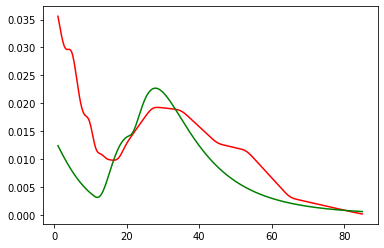

mu: 2.855, scale: [0.3056 0.2999 0.3013], sigma: [0.4096 0.6201 0.7294], bias: [-19.9998  10.      20.0001], loss: 4.75609e-05
mu: 3.133, scale: [0.5276 0.3658 0.3197], sigma: [0.2957 0.6302 0.6675], bias: [-19.9972   9.9973  20.0069], loss: 1.59907e-06
mu: 3.144, scale: [0.4972 0.3985 0.297 ], sigma: [0.2775 0.6411 0.6511], bias: [-20.0062   9.9984  20.0096], loss: 1.49995e-06
mu: 3.15, scale: [0.4841 0.4116 0.2878], sigma: [0.2699 0.6418 0.6518], bias: [-20.0153   9.9994  20.0125], loss: 1.48486e-06
mu: 3.152, scale: [0.4804 0.4158 0.2848], sigma: [0.2676 0.642  0.652 ], bias: [-20.0245  10.      20.0158], loss: 1.48172e-06
mu: 3.153, scale: [0.4795 0.4172 0.2836], sigma: [0.267  0.6419 0.6519], bias: [-20.0337  10.0006  20.0191], loss: 1.47966e-06
mu: 3.153, scale: [0.4794 0.4179 0.283 ], sigma: [0.2669 0.6417 0.6517], bias: [-20.043   10.0011  20.0225], loss: 1.4777e-06
mu: 3.154, scale: [0.4796 0.4184 0.2826], sigma: [0.2669 0.6415 0.6515], bias: [-20.0522  10.0017  20.0259], loss

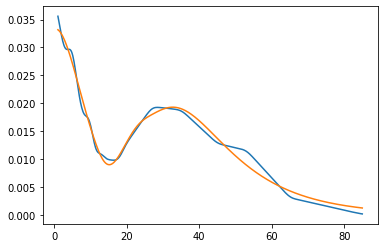

In [6]:

cols = ['Unnamed', 'Days', 'Catches']
csv = pd.read_csv('C:/work/ImageProcDocs/Python-playground/FishPopulation/nosed.csv')
y0 = csv[cols[2]]
y = y0 / sum(y0)
x0 = list(range(1,len(y)+1,1))
fI = scipy.interpolate.interp1d(x0, y, kind='linear')
xI = np.linspace(x0[0],x0[-1], 512)
yI = fI(xI)
zI = gaussian_filter1d(yI, 6, mode='nearest')

# nosed
#scale = [0.5,0.4,0.1]
#aa=11
#bias = [0 - aa,27-aa,50-aa]
#mu = 2.85
#sigma = [0.4,0.55,0.6]

#zA = sum(XlogNorm(xI,scale[i],bias[i],mu,sigma[i]) for i in range(0,3))
#plt.plot(xI, yI)
#plt.plot(xI,zA)
#plt.plot(xI, zI)
#plt.show()

scale=[0.3,0.3,0.3]
sh=20
bias=[0-sh,30-sh,40-sh]
mu=2.85
sigmaInc=[0.4,0.2,0.1]

alg = GradDescentAlg(scale, bias, mu, sigmaInc)
loss, Y = alg.forward(xI, zI)
print("orig loss: ", loss)
plt.plot(xI, zI, 'r')
plt.plot(xI, Y, 'g')
plt.show()

batchSz = 512
np.set_printoptions(precision=4)
xB = xI.reshape((-1,batchSz))
zB = zI.reshape((-1,batchSz))
for i in range(1000000):
    output = i % 1000 == 0
    loss = 0.0
    for (X,Z) in zip(xB,zB):
      loss = np.maximum(loss,alg.backpropVector(X, Z, 50, output))
    if loss < 1e-6:
       break

loss, Y = alg.forward(xI, zI)
plt.plot(xI, zI)
plt.plot(xI, Y)
plt.show()

orig loss:  1.3558574939103265e-05


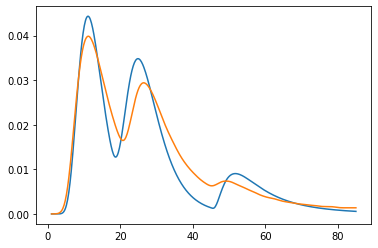

mu: 2.523, scale: [0.3987 0.3925 0.1453], sigma: [0.3263 0.4552 0.7765], bias: [1.3756e-04 1.5001e+01 4.5000e+01], loss: 1.35586e-05
mu: 2.661, scale: [0.5131 0.343  0.1439], sigma: [0.4079 0.4179 1.0454], bias: [-0.4165 15.5059 44.9435], loss: 1.80263e-06
mu: 2.669, scale: [0.5177 0.3443 0.1443], sigma: [0.4082 0.4182 1.0858], bias: [-0.5682 15.7176 44.9119], loss: 1.42457e-06
mu: 2.672, scale: [0.5201 0.3446 0.1437], sigma: [0.4093 0.4193 1.0865], bias: [-0.6156 15.8206 44.8864], loss: 1.3532e-06
mu: 2.672, scale: [0.5214 0.3446 0.1431], sigma: [0.4104 0.4204 1.0818], bias: [-0.6202 15.8798 44.8627], loss: 1.33197e-06
mu: 2.671, scale: [0.522  0.3446 0.1426], sigma: [0.4114 0.4214 1.0771], bias: [-0.6066 15.9206 44.8398], loss: 1.31981e-06
mu: 2.67, scale: [0.5224 0.3445 0.1422], sigma: [0.4124 0.4224 1.073 ], bias: [-0.5852 15.9535 44.8174], loss: 1.30942e-06
mu: 2.668, scale: [0.5226 0.3444 0.1419], sigma: [0.4134 0.4234 1.0692], bias: [-0.5604 15.983  44.7952], loss: 1.29945e-06
m

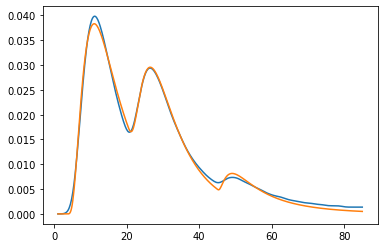

In [8]:

cols = ['Unnamed', 'Days', 'Catches']
csv = pd.read_csv('C:/work/ImageProcDocs/Python-playground/FishPopulation/white.csv')
y0 = csv[cols[2]]
y = y0 / sum(y0)
x0 = list(range(1,len(y)+1,1))
fI = scipy.interpolate.interp1d(x0, y, kind='linear')
xI = np.linspace(x0[0],x0[-1], 512)
yI = fI(xI)
zI = gaussian_filter1d(yI, 5, mode='nearest')

scale=[0.4,0.4,0.15]
bias=[0,15,45]
mu=2.5
sigmaInc=[0.3,0.11,0.31]

alg = GradDescentAlg(scale, bias, mu, sigmaInc)
loss, Y = alg.forward(xI, zI)
print("orig loss: ", loss)

plt.plot(xI, Y)
plt.plot(xI, zI)
plt.show()

i = 0
while i < 5e5:
  output = i % 1000 == 0
  loss = alg.backpropVector(xI, zI, 200, output)
  i += 1
  if loss < 2e-7:
     break

loss, Y = alg.forward(xI, zI)
plt.plot(xI, zI)
plt.plot(xI, Y)
plt.show()

In [ ]:

def relu(x):
  beta = 20
  return 1/beta * sym.ln(1 + sym.exp(beta*x))

def logNorm(x, scale, sigma, mu):
  # sigmas must be positive and always increase
   return scale * (sym.exp(-(sym.ln(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * sym.sqrt(2 * sym.pi)))

def scaleSoft(scale1,scale2,scale3):
  es = (sym.exp(scale1), sym.exp(scale2), sym.exp(scale3))
  s = es[0] + es[1] + es[2]
  return es[0] / s

def sigmas(sigmaInc1,sigmaInc2,sigmaInc3):
  s1 = relu(sigmaInc1) + 0.01
  s2 = s1 + relu(sigmaInc2) + 0.01
  s3 = s2 + relu(sigmaInc3) + 0.01
  return (s1,s2,s3)

def biases(x, bias):
  return relu(x - bias) + 1e-9

def Y(x):
  A = logNorm1 + logNorm2 + logNorm3
  return A

#bias = sym.IndexedBase('bias')
#sigmaInc1,sigmaInc2,sigmaInc3 = sym.symbols('sigmaInc1 sigmaInc2 sigmaInc3')
sigmaInc = sym.Indexed('sigma',j)
scale1,scale2,scale3 = sym.symbols('scale1 scale2 scale3')
bias1,bias2,bias3 = sym.symbols('bias1 bias2 bias3')
x,mu,sigma,bias,scale,N = sym.symbols('x mu sigma bias scale N')

A = logNorm(x, scale, sigma, mu)
print("dAx: ", str(sym.diff(A,x).simplify()))
print("dAscale: ", str(sym.diff(A,scale).simplify()))
print("dAsigma: ", str(sym.diff(A,sigma).simplify()))
print("dAmu: ", str(sym.diff(A,mu).simplify()))

S = scaleSoft(scale1,scale2,scale3)
print("dsoftmax1: ", str(sym.diff(S,scale1).simplify()))
print("dsoftmax2: ", str(sym.diff(S,scale2).simplify()))
print("dsoftmax3: ", str(sym.diff(S,scale3).simplify()))

V = relu(x - bias) + 1e-9
print("dbiasX:", str(sym.diff(V,bias).simplify()))

xi = sym.Indexed('x',i)
yi = sym.Indexed('y',i)

J = 1/N*sym.Sum((xi - yi)**2,(i,1,N))
U = sym.Sum(sym.exp(xi)**1,(i,1,N)) / sym.exp(xi)**2
print("loss: ", sym.diff(J,yi), U, sym.diff(U,xi))



dAx:  sqrt(2)*scale*(mu - sigma**2 - log(x))*exp(-(mu - log(x))**2/(2*sigma**2))/(2*sqrt(pi)*sigma**3*x**2)
dAscale:  sqrt(2)*exp(-(mu - log(x))**2/(2*sigma**2))/(2*sqrt(pi)*sigma*x)
dAsigma:  sqrt(2)*scale*(-sigma**2 + (mu - log(x))**2)*exp(-(mu - log(x))**2/(2*sigma**2))/(2*sqrt(pi)*sigma**4*x)
dAmu:  -sqrt(2)*scale*(mu - log(x))*exp(-(mu - log(x))**2/(2*sigma**2))/(2*sqrt(pi)*sigma**3*x)
dsoftmax1:  (exp(scale2) + exp(scale3))*exp(scale1)/(exp(scale1) + exp(scale2) + exp(scale3))**2
dsoftmax2:  -exp(scale1 + scale2)/(exp(scale1) + exp(scale2) + exp(scale3))**2
dsoftmax3:  -exp(scale1 + scale3)/(exp(scale1) + exp(scale2) + exp(scale3))**2
dbiasX: -1.0/(exp(20*bias - 20*x) + 1)
loss:  Sum(-2*x[i] + 2*y[i], (i, 1, N))/N exp(-2*x[i])*Sum(exp(x[i]), (i, 1, N)) -exp(-2*x[i])*Sum(exp(x[i]), (i, 1, N))
